# IPython Notebook for turning in solutions to the problems in the Essentials of Paleomagnetism Textbook by L. Tauxe

## Problems in Chapter 11

## Problem 1a

After finding the command line, you can type:  

fishrot.py -n 20 -D 12 -I 45 -k 25 >ps11_prob1a.dat

and then 

eqarea.py -f ps11_prob1a.dat

and display the png.    

OR, you can use the programs from within this notebook, like this: 


In [24]:
!fishrot.py -n 20 -D 12 -I 45 -k 25 >ps11_prob1a.dat

In [25]:
!eqarea.py -f prob1a.dat -sav -fmt png

1  saved in  prob1a.dat.png


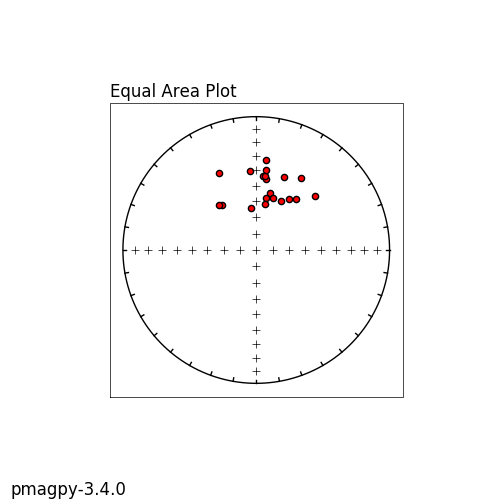

In [26]:
from IPython.display import Image
Image(filename='ps11_prob1a.dat.png')

For the challenge problem, we need to call a few functions from pmag, ipmag and pmagplotlib to create the Fisher distributed set of directions and then plot them.  

In [27]:
# import PmagPy functions
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.ipmag as ipmag 
import numpy as np # while we are at it, let's import numpy
import matplotlib.pyplot as plt # set up for plotting 
%matplotlib inline


The pmag module has two functions we can use here,  fshdev(kappa), which generates fisher distributed directions from a distribution with kappa and a vertical true mean direction, and dodirot(D,I,Dbar,Ibar), which rotates a direction to a new reference direction of Dbar, Ibar.  

In [46]:
def fishy(N,kappa,Dbar,Ibar):  # let's write this as a function we can re-use
    """
    call to fishy(N,kappa,Dbar,Ibar) returns lists of D,I drawn from 
    distribution with true mean Dbar,Ibar.
    """
    D,I=[],[] # set up containers for our fisher distributed Decs and Incs
    for i in range(N): # do this 20 times
        dec,inc=pmag.fshdev(kappa)# draws point from fisher distributio
        # rotate to Dbar,Ibar coordinate system ()
        drot,irot=pmag.dodirot(dec,inc,Dbar,Ibar)
        D.append(drot)
        I.append(irot)
    return np.array([D,I]) # numpy has to be imported first
N,kappa=20,25 # we want 20 directions drawn from a Fisher distribution with kappa=25. 
Dbar,Ibar=12,45 # we want to rotate these from vertical to a true meanof Dbar and Ibar
DI=fishy(N,kappa,Dbar,Ibar)


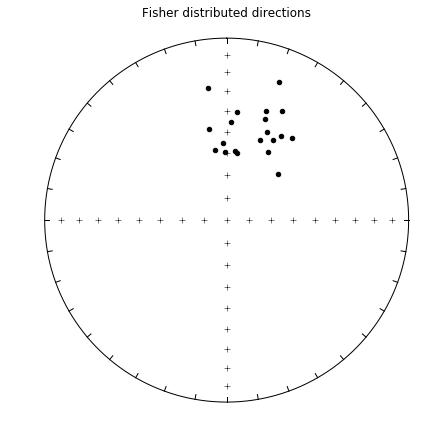

In [29]:
plt.figure(num=1,figsize=(6,6),dpi=160) # set up the figure object
ipmag.plot_net(1) # plot the equal area net
ipmag.plot_di(DI[0],DI[1]) # put on the directions
plt.title("Fisher distributed directions") # give it a title

## Problem 1b

Here we have to write a program to read in the data from Problem 1a and calcualate the Fisher statistics. We can re-use some of the code we wrote before (dir2cart and cart2dir) (which also happen to be part of the pmag module) and write a new function for doing the fisher statistics.  Notice the use of a doc string (enclosed in triple quotes) at the front of the function. 

In [30]:
def fisher_mean(data):
    """
    calculates fisher statistics for data
    """
    R = 0 # initialize R, the resultant vector length to zero
    Xbar,X=[0,0,0],[]# initialize Xbar, the container for mean x,y,z
    fpars={} # dictionary for the Fisher statistics
    N=len(data) # number of data points incoming
    if N <2: # You can't do Fisher statistics on less than 2 numbers. 
       return fpars
    # call to dir2cart transforms directions to cartesian coordinates
    X=pmag.dir2cart(data) # pmag needs to be imported before calling. 
    for i in range(len(X)):
        for c in range(3):
           Xbar[c]+=X[i][c]  # get the sum of each cartesian coordinate
    for c in range(3):
        R+=Xbar[c]**2  # get the sum of squares of the component sums.  
    R=np.sqrt(R) # take the square root
    for c in range(3):
        Xbar[c]=Xbar[c]/R  # normalize by the Resultant vector length
    dir=pmag.cart2dir(Xbar) # convert back to directions
    fpars["dec"]=dir[0]
    fpars["inc"]=dir[1]
    fpars["n"]=N
    fpars["r"]=R
    if N!=R: # if perfectly aligned kappa infinite! 
        k=(N-1.)/(N-R)
        fpars["k"]=k
        csd=81./np.sqrt(k)
    else:
        fpars['k']='inf'
        csd=0.
    b=20.**(1./(N-1.)) -1
    a=1-b*(N-R)/R
    if a<-1:a=-1
    a95=np.arccos(a)*180./np.pi
    fpars["alpha95"]=a95
    fpars["csd"]=csd
    if a<0: fpars["alpha95"] = 180.0
    return fpars


In [31]:
data=np.loadtxt('ps11_prob1a.dat') # read in the data from problem 1a
fpars= fisher_mean(data)
print fpars # it isn't pretty, but it works.  

{'csd': 15.426672130815289, 'k': 27.569287285881298, 'n': 20, 'r': 19.310827305654353, 'alpha95': 6.3290779342630019, 'dec': 14.987347974896657, 'inc': 43.984592369353443}


## Problem 1c

We could use fishrot.py - OR - we could use our own little function, fishy,  we wrote in Problem 1a.   

In [57]:
DI2=fishy(N,kappa,Dbar,Ibar).transpose()
fpars2=fisher_mean(DI2)
print fpars2

{'csd': 16.663013756570631, 'k': 23.629957037911669, 'n': 20, 'r': 19.195935905870815, 'alpha95': 6.8573441783447375, 'dec': 9.8731751230940894, 'inc': 42.16071600553645}


Now we can write a little function to calculate Watson's F statistic (Equation 11.16 in the Essentials textbook).  

In [55]:
def watsonsF(DI1,DI2):
    # first calculate R for the combined data set, then R1 and R2 for each individually.
    DI=np.concatenate((DI1,DI2),axis=0) # create a new array from two smaller ones
    fpars=fisher_mean(DI) # re-use our functionfrom problem 1b
    fpars1=fisher_mean(DI1)
    fpars2=fisher_mean(DI2)
    N=fpars['n']
    R=fpars['r']
    R1=fpars1['r']
    R2=fpars2['r']
    F=(N-2.)*((R1+R2-R)/(N-R1-R2))
    return F

And now we call it. 

In [58]:
# if you print out data and DI2, you will see that DI2 needs to be transposed into a 2xn array
# with decs and incs
print 'F = %10.5f'%(watsonsF(data,DI2)) 

F =    0.64448


So, how do we figure out what the critical value of F is?  I found this website with F tables at:
http://www.socr.ucla.edu/Applets.dir/F_Table.html
looking at the table for $\alpha$=0.05 (95% confidence) and 2(N-2) degrees of freedom, I found the value of 3.117.  Our value above is much lower than that, so indeed these two data sets are probably drawn from the same distribution.  

## Problem 1d

So here all our work will pay off, because we can just re-use the functions we already wrote.  

In [59]:
DI3=fishy(N,kappa,55,60).transpose()
print 'F = %10.5f'%(watsonsF(data,DI3))  # we already did the tranpose thing

F =   25.28207


And those two are clearly NOT drawn from the same distribution!

To check with the PmagPy program watonsF.py, we need to save the data and run that program on the command line.

In [60]:
np.savetxt('ps11_prob1c.dat',DI2) # saves as a text file
np.savetxt('ps11_prob1d.dat', DI3) 

Now we can use the program, watsons_f.py to calculate the F statistic.  But first it would be nice to know how it works:  


In [61]:
!watsons_f.py -h


    NAME
       watsonsF.py

    DESCRIPTION
       calculates Watson's F statistic from input files

    INPUT FORMAT
       takes dec/inc as first two columns in two space delimited files
   
    SYNTAX
       watsonsF.py [command line options]

    OPTIONS
        -h prints help message and quits
        -f FILE (with optional second)
        -f2 FILE (second file) 
        -ant,  flip antipodal directions in FILE to opposite direction

    OUTPUT
        Watson's F, critical value from F-tables for 2, 2(N-2) degrees of freedom

    


So now we do this:

In [62]:
!watsons_f.py -f ps11_prob1a.dat -f2 ps11_prob1c.dat

   0.64    3.12


These are the values for F and the critical value of F for this N.   0.6 is way less than 3.1, so these two data sets are likely drawn from the same distribution.  

Now we re-run it with ps11_prob1d.dat and see what we get:  

In [63]:
!watsons_f.py -f ps11_prob1a.dat -f2 ps11_prob1d.dat

  25.28    3.12


Looks like these two are different....    
So our code is working the same way watsons_f.py works.  

## Problem 1d

Now we can run PmagPy's  watsons_v.py from the command line and see how the two methods compare. 


In [64]:
!watsons_v.py -f ps11_prob1a.dat -f2 ps11_prob1c.dat -fmt png -sav

Watson's V,  Vcrit: 
          1.3        6.2
1  saved in  WatsonsV_ps11_prob1a.dat_ps11_prob1c.dat.png


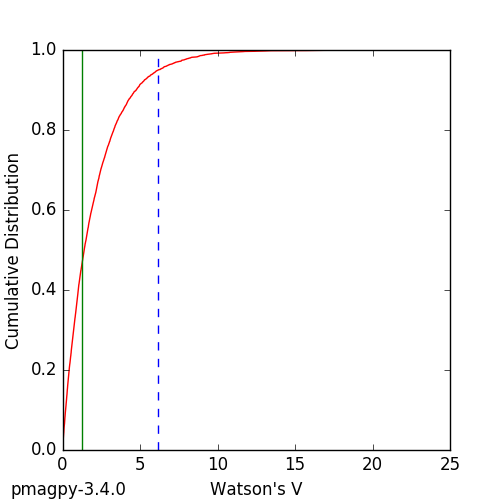

In [65]:
Image(filename='WatsonsV_ps11_prob1a.dat_ps11_prob1c.dat.png')

Re-doing this for the other pair of files:

In [ ]:
Image(filename='ps11_prob1e_2.png')

In [66]:
!watsons_v.py -f ps11_prob1a.dat -f2 ps11_prob1d.dat -fmt png -sav

Watson's V,  Vcrit: 
         50.5        6.1
1  saved in  WatsonsV_ps11_prob1a.dat_ps11_prob1d.dat.png


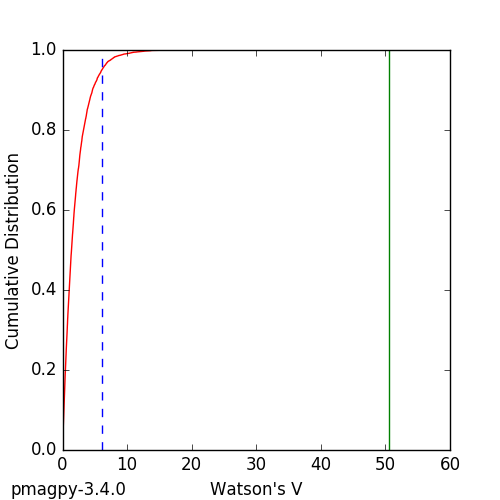

In [67]:
Image(filename='WatsonsV_ps11_prob1a.dat_ps11_prob1d.dat.png')

So the two methods give the same answer.  

## Problem 2a

For this, we re-use our function fishy above and calculate the average inclination value (using Gaussian statistics).   I'm having so much fun scripting that I'm going to write my own program to average a list of numbers.  

In [86]:
DI4=DI=fishy(N,kappa,0,70) # I'm using the same N and kappa as for the others
Incs=DI4[1]

In [69]:
def average(data):
    Xbar=0
    for i in range(len(data)):
        Xbar+=data[i]
    return Xbar/len(data) # that was quick

In [87]:
print average(Incs)

63.9113453859


## Problem 2b

For this, I can re-use fisher_mean from above.  I like this function stuff - it saves a lot of time!

In [88]:
print fisher_mean(DI4.transpose())['inc']

67.8007668439


See how the Fisher mean is steeper than the gaussian mean?  

## Program 2c

Well I'm totally going to call pmag.doincfish from inside this notebook.  

In [92]:
print pmag.doincfish(Incs)

{'ginc': 63.911345385861672, 'k': 29.33607766493428, 'n': 20, 'r': 19.352333320868219, 'alpha95': 0.9962580831312331, 'csd': 14.954916603585268, 'inc': 66.081345385861539}


So that program did pretty well at fixing the problem!

## Problem 3a

For this problem, we first need to read in the data file ps11_prob3a.dat  from the Chapter\_11 folder and peel off the declination, inclination data.  

In [73]:
data=np.loadtxt('Chapter_11/ps11_prob3a.dat') # read in the data
import pandas as pd  # let's use this cool module for wrangling data!
frame=pd.DataFrame(data,columns=['dec','inc','dip_dir','dip'])
print frame.head()

     dec   inc  dip_dir   dip
0    9.7  53.0    105.0  22.0
1  317.0  44.2    105.0  22.0
2  333.1   8.9    105.0  22.0
3  354.3  -0.1    105.0  22.0
4  338.9  50.2    105.0  22.0


And because we now know how, let's make a quickie plot.  

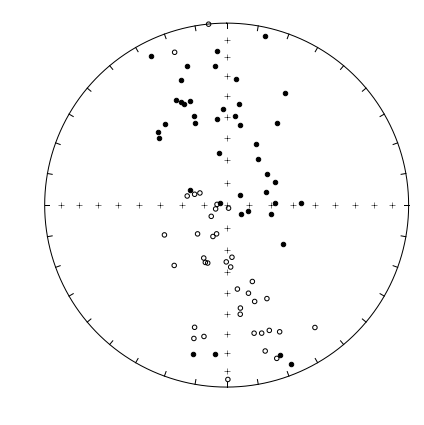

In [74]:
DI=np.array([frame['dec'],frame['inc']]).transpose() # peel out the decs and incs and make a new array
plt.figure(num=2,figsize=(6,6),dpi=160) # set up the figure object
ipmag.plot_net(2) # plot the equal area net
ipmag.plot_di(frame['dec'],frame['inc']) # put on the directions

Now we can use the function pmag.doprinc to calculate the principal component of the directional data.

In [75]:
princ_pars=pmag.doprinc(DI)
print princ_pars

{'V3inc': 11.089856927852408, 'V3dec': 253.50393161917111, 'V2inc': 34.703324574333955, 'V2dec': 155.70255066070376, 'Edir': array([ 335.70255066,  -34.70332457,    1.        ]), 'N': 80, 'tau2': 0.2306561374717023, 'tau3': 0.046249398148129589, 'tau1': 0.723094464380168, 'dec': 358.61577458597367, 'inc': 53.062603657226525}


Any vector with an angle of > 90 from the principal direction princ_pars['dec'] and princ_pars['inc'] belongs in the reverse polarity group.  So we can use the function pmag.angle to separate the two groups. First let's paste on the principal directions to our panda frame.

In [76]:
frame['principal_dec']=princ_pars['dec'] # add the principal components to the panda frame.
frame['principal_inc']=princ_pars['inc']
print frame.head() # I love how this works

     dec   inc  dip_dir   dip  principal_dec  principal_inc
0    9.7  53.0    105.0  22.0     358.615775      53.062604
1  317.0  44.2    105.0  22.0     358.615775      53.062604
2  333.1   8.9    105.0  22.0     358.615775      53.062604
3  354.3  -0.1    105.0  22.0     358.615775      53.062604
4  338.9  50.2    105.0  22.0     358.615775      53.062604


Let's find out what pmag.angle expects.   

In [77]:
print pmag.angle.__doc__


    call to angle(D1,D2) returns array of angles between lists of two directions D1,D2 where D1 is for example, [[Dec1,Inc1],[Dec2,Inc2],etc.]
    


So first we have to set up D2 with the principal directions (DI1 is already set up - it is DI). Then we call pmag.angle.

In [78]:
PD=np.array([frame['principal_dec'],frame['principal_inc']]).transpose()
frame['angle']=pmag.angle(DI,PD)
print frame.head()

     dec   inc  dip_dir   dip  principal_dec  principal_inc      angle
0    9.7  53.0    105.0  22.0     358.615775      53.062604   6.659466
1  317.0  44.2    105.0  22.0     358.615775      53.062604  28.438617
2  333.1   8.9    105.0  22.0     358.615775      53.062604  48.741348
3  354.3  -0.1    105.0  22.0     358.615775      53.062604  53.284495
4  338.9  50.2    105.0  22.0     358.615775      53.062604  12.524863


Now all we have to do is test the angle and sort the two directions into their own frames.

In [79]:
Mode_1= frame.ix[frame['angle']<=90] # these are the normal directions
Mode_2=frame.ix[frame['angle']>90] # these are the reverse directions

In [80]:
Mode_2_flip=Mode_2.copy() # make a copy of Mode_2.  
Mode_2_flip['dec']=(Mode_2['dec']-180.)%360. # subtracts 180 but does modular 360 (stays 0=>360 this way.)
Mode_2_flip['inc']=-Mode_2['inc'] # take the negative of the inclination
flip_frame=pd.concat([Mode_1,Mode_2_flip]) # this is the list of all the data, flipping the reverse mode.

Now we can call our old friend fisher_mean from Problem 1b and finish the job. 

In [81]:
DIflip=np.array([flip_frame['dec'],flip_frame['inc']]).transpose()
geo_stats=fisher_mean(DIflip)
# print out the statistics for the (flipped) geographic reference frame.
print 'Fisher statistics for flipped data set',geo_stats

Fisher statistics for flipped data set {'csd': 33.057030603962104, 'k': 6.0040231493049898, 'n': 80, 'r': 66.842155995160539, 'alpha95': 7.0721041360252466, 'dec': 358.94196930277531, 'inc': 51.257553593765508}


Now we have to call pmag.dotilt  as we did in Chapter 9, but now stepping through the pandas frame.

In [82]:
dec_rot,inc_rot=[],[]
for i in range(len(flip_frame.dec)):
    drot,irot=pmag.dotilt(flip_frame.ix[i].dec,flip_frame.ix[i].inc,flip_frame.ix[i].dip_dir,flip_frame.ix[i].dip)
    dec_rot.append(drot)
    inc_rot.append(irot)
flip_frame['dec_rot']=dec_rot
flip_frame['inc_rot']=inc_rot

Repeat fisher_mean call with tilt corrected data: 

In [83]:
DItilt=np.array([flip_frame['dec_rot'],flip_frame['inc_rot']]).transpose()
tilt_stats=fisher_mean(DItilt)
print 'Fisher statistics for Mode 1',tilt_stats

Fisher statistics for Mode 1 {'csd': 22.448281345346874, 'k': 13.019785947683799, 'n': 80, 'r': 73.932311919916472, 'alpha95': 4.5647302763823205, 'dec': 359.13686781062501, 'inc': 36.082941162612748}


To finish this off, we take the ratio of the two k values (before and after tilt) and compare with the F-table values ($\alpha$=.05 and degrees of freedom 2(N1-1) and 2(N2-1).   Now you should know that there is also a pmag.fcalc()

In [84]:
print geo_stats['k']/tilt_stats['k']

0.461146072096


In [85]:
print pmag.fcalc(2*geo_stats['n']-1,2*tilt_stats['n'])

1.6366


So our F value would pass the McElhinny fold test.